In [57]:
# # # # Web scraping: Africa in International Math Olympiads # # # #

In [58]:
# Importing packages

import requests,math
import numpy as np
from bs4 import BeautifulSoup

In [59]:
# # Data about performance of countries at the IMO

URL_imo = 'https://www.imo-official.org/results.aspx'
page_imo = requests.get(URL_imo)
imo = BeautifulSoup(page_imo.content, 'html.parser')
results_imo = imo.find(id='main')

countries_imo = results_imo.find_all('tr')
countries_imo.pop(0)
countries_imo.pop(0)

year = [results_imo.find_all('tr')[0]('th')[i]('a')[0]['title'][4:] for i in range(1,len(results_imo.find_all('tr')[0]('th'))-1)]
code = [0 for i in range(len(countries_imo))] # country codes
name = [0 for i in range(len(countries_imo))] # country names
data = [[float('nan') for y in year] for i in code] # country performance at IMO

for i in range(len(countries_imo)):
    code[i] = countries_imo[i].a.text
    name[i] = countries_imo[i].a['title']
    
for c in range(len(code)):
    for y in range(len(year)):
        if not (countries_imo[c].find_all('td')[y+1].a is None): # making sure <a> exists
            if ("team_r.aspx?" in countries_imo[c].find_all('td')[y+1].a["href"]): # if the country c participated the year y
                data[c][y] = int(countries_imo[c].find_all('td')[y+1].a.text)

In [60]:
# # African countries

URL_africa = 'https://allafrica.com/misc/sitemap/countries.html' # list of African countries
page_africa = requests.get(URL_africa)
africa = BeautifulSoup(page_africa.content, 'html.parser')
results_africa = africa.find(class_='category-grid')
countries_africa = np.array([results_africa.find_all('a')[c].text.replace(u'\xa0', u' ') for c in range(1,len(results_africa.find_all('a')))])
countries_africa[countries_africa == "Cote d'Ivoire"] = "Côte d'Ivoire"

In [61]:
# # Need to identify African countries (linking the two data bases)

name2 = np.array(name)
name2[name2 == 'Ivory Coast'] = "Côte d'Ivoire"

#african_participant = [0 for c in name] # value 0 if African country never participated to IMO
african_participant = []

i=0
for c in range(len(name2)):
    if name2[c] in countries_africa:
        #african_participant[c] = 1 # value 1 if African country  participated to at least one IMO edition
        african_participant.append(c) # their position in IMO countries list ('name')
    i=i+1
    
africa_performance = [data[a] for a in african_participant] # performance of African countries

In [62]:
# # Some statistics

len(african_participant); # 20 African countries at the IMO

np.nanmin(africa_performance,axis=1); # best performance for each African country

name2[african_participant[np.argmin(np.nanmin(africa_performance,axis=1))]],
np.nanmin(africa_performance),
year[np.nanargmin(data[african_participant[np.argmin(np.nanmin(africa_performance,axis=1))]])];
# Morocco achieved the best performance for an African country, 18, in 1982

np.nanmax(africa_performance),
sum(sum(africa_performance[a]==np.nanmax(africa_performance) for a in range(len(africa_performance)-1))); # worst performance accross all African countries:110. Achieved 3 times

In [63]:
# Relative performance: rank divided by number of participants

data_standardized = [[float('nan') for y in year] for i in code]

for i in range(len(code)):
    for y in range(len(year)):
        if not(math.isnan(data[i][y])):
            data_standardized[i][y] = np.divide(data[i][y],np.nanmax(data,axis=0)[y])
            
africa_performance_standardized = [data_standardized[a] for a in african_participant] # performance of African countries

In [64]:
np.nanmin(africa_performance_standardized,axis=1); # best relative performance for each African country

name[african_participant[np.argmin(np.nanmin(africa_performance_standardized,axis=1))]],
np.nanmin(africa_performance_standardized),
year[np.nanargmin(data[african_participant[np.argmin(np.nanmin(africa_performance_standardized,axis=1))]])];
# Morocco achieved the best relative performance for an African country in 1982

In [65]:
name[african_participant[np.argmin(np.nanmin(africa_performance_standardized,axis=1))]],
np.nanmin(africa_performance_standardized),
year[np.nanargmin(data[african_participant[np.argmin(np.nanmin(africa_performance_standardized,axis=1))]])];

In [66]:
# Map: for each African country, its best performance at IMO

# Help: https://medium.com/using-specialist-business-databases/creating-a-choropleth-map-using-geopandas-and-financial-data-c76419258746

In [67]:
# Needed to install geopandas through Anaconda Prompt, by running the code "conda install -c conda-forge geopandas"

In [68]:
import pandas as pd #used to read in the revenue file 
import matplotlib.pyplot as plt #for plotting
#to read in shape file and provides high #level interface with #matplotlib library for making maps
import geopandas as gpd

# Available data sets
# gpd.datasets.available

#import world shape map externally, no need to have a saved file
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# view first 5 rows
# world.head()

#inspect count
# world.info()

In [69]:
# merge both data sets using country code/iso_a3 as unique identifiers

score = pd.DataFrame({'abs_rank':np.nanmin(np.array(data)[african_participant],axis=1),
                      'rel_rank':np.nanmin(np.array(data_standardized)[african_participant],axis=1)},
                     index=name2[african_participant]); # consider working with DataFrames from the beginning

for_plotting = world.merge(score, left_on = 'name', right_index=True)
#for_plotting.info() #check the occurrence

In [70]:
# Needed to install mapclassify and descartes through Anaconda Prompt, by running codes like "conda install -c conda-forge mapclassify"

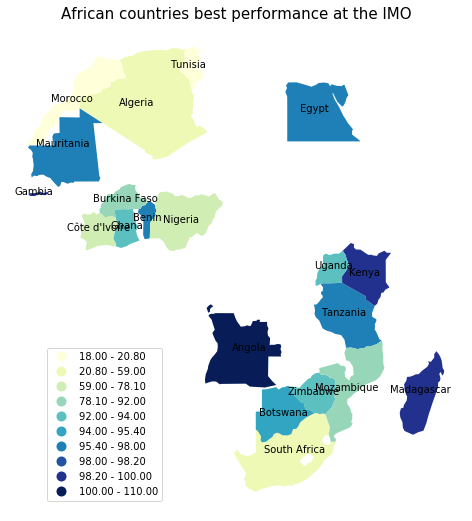

In [72]:
# Map
carte = for_plotting.plot(column='abs_rank', cmap =    
                                'YlGnBu', figsize=(15,9),   
                                 scheme='quantiles', k=10, legend =  
                                 True);
# Title
carte.set_title('African countries best performances at the IMO', fontdict={'fontsize':15});

# Remove axes
carte.set_axis_off();

#move legend to an empty space
carte.get_legend().set_bbox_to_anchor((.35,.35));
#carte.get_figure()

# Adding Labels (country names)

for_plotting['coords'] = for_plotting['geometry'].apply(lambda x: x.representative_point().coords[:])
for_plotting['coords'] = [coords[0] for coords in for_plotting['coords']]
for idx, row in for_plotting.iterrows():
    carte.annotate(s=row['name'], xy=row['coords'],horizontalalignment='center')
#carte.get_figure()

In [ ]:
# Plot: for each African country, evolution of its performance at IMO

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,abs_rank,rel_rank
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",98.0,0.954545
13,47615739,Africa,Kenya,KEN,152700.0,"POLYGON ((39.20222 -4.67677, 37.76690 -3.67712...",99.0,0.908257
25,54841552,Africa,South Africa,ZAF,739100.0,"POLYGON ((16.34498 -28.57671, 16.82402 -28.082...",27.0,0.333333
48,13805084,Africa,Zimbabwe,ZWE,28330.0,"POLYGON ((31.19141 -22.25151, 30.65987 -22.151...",94.0,0.930693
49,2214858,Africa,Botswana,BWA,35900.0,"POLYGON ((29.43219 -22.09131, 28.01724 -22.827...",95.0,0.887850


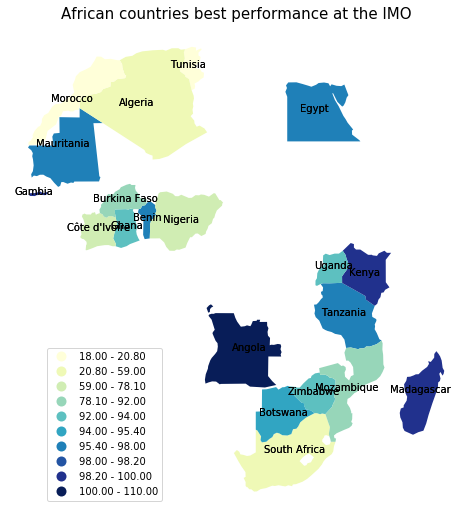

TypeError: 'generator' object is not subscriptable